In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm
from scipy.optimize import minimize
from skfda import FDataGrid
from skfda.preprocessing.smoothing import BasisSmoother
from skfda.representation.basis import FourierBasis
from skfda.exploratory.visualization import FPCAPlot
from sklearn.cluster import KMeans
from sklearn.pipeline import make_pipeline
from skfda.preprocessing.dim_reduction.feature_extraction import FPCA
from joblib import Parallel, delayed
from tqdm import tqdm

C:\Users\sunwoong\AppData\Local\Temp\ipykernel_16528\1557460481.py:13: DeprecationWarning: The module "feature_extraction" is deprecated.Please use "dim_reduction" for FPCAor "feature_construction" for feature construction techniques
  from skfda.preprocessing.dim_reduction.feature_extraction import FPCA


## 레벨에 따른 데이터 재구성

In [2]:
data_dir="currency_integrated_pannel.csv"
data=pd.read_csv(data_dir, encoding=False)
data_syn=pd.read_csv("levelups_panel_20240722.csv",encoding='utf-8')

In [3]:
data_syn

,player_slug,character_slug,first_session_level,binger,total_purchase,total_ad,highest_level,status,level_from,level_to,...,playtime_tower,playtime_pvp,playtime_farm,playtime_survival,playtime_side,date_event,date_event_prev,same_date,date_interval,binge
0,2021-10-31T16:01:57.631Z,킹덤,2,0,0.0,0.0,7,complete,1,2,...,0.0,0.0,0.0,0.0,0.0,2021-11-04,2021-11-04,True,0.009444,1
1,2021-10-31T16:01:57.631Z,킹덤,2,0,0.0,0.0,7,complete,2,3,...,0.0,0.0,0.0,0.0,0.0,2021-11-13,2021-11-04,False,5.426389,1
2,2021-10-31T16:01:57.631Z,킹덤,2,0,0.0,0.0,7,complete,3,4,...,0.0,0.0,0.0,0.0,0.0,2021-11-13,2021-11-13,True,5.426389,1
3,2021-10-31T16:01:57.631Z,킹덤,2,0,0.0,0.0,7,complete,4,5,...,0.0,0.0,0.0,0.0,0.0,2021-11-13,2021-11-13,True,5.426389,1
4,2021-10-31T16:01:57.631Z,킹덤,2,0,0.0,0.0,7,complete,5,6,...,0.0,0.0,0.0,0.0,0.0,2021-11-13,2021-11-13,True,5.426389,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2466992,2022-03-30T14:36:22.522Z,킹키킹,8,0,0.0,0.0,8,complete,3,4,...,0.0,0.0,0.0,0.0,0.0,2022-03-30,2022-03-30,True,0.236667,0
2466993,2022-03-30T14:36:22.522Z,킹키킹,8,0,0.0,0.0,8,complete,4,5,...,0.0,0.0,0.0,0.0,0.0,2022-03-30,2022-03-30,True,0.236667,0
2466994,2022-03-30T14:36:22.522Z,킹키킹,8,0,0.0,0.0,8,complete,5,6,...,0.0,0.0,0.0,0.0,0.0,2022-03-30,2022-03-30,True,0.236667,0
2466995,2022-03-30T14:36:22.522Z,킹키킹,8,0,0.0,0.0,8,complete,6,7,...,0.0,0.0,0.0,0.0,0.0,2022-03-30,2022-03-30,True,0.236667,0


In [4]:
data=data[['player_slug','final_currency_usage','final_dia_currency_usage']]
data

,player_slug,final_currency_usage,final_dia_currency_usage
0,2021-10-31T16:01:57.631Z,0,0
1,2021-10-31T16:01:57.631Z,0,0
2,2021-10-31T16:01:57.631Z,0,0
3,2021-10-31T16:01:57.631Z,0,0
4,2021-10-31T16:01:57.631Z,0,0
...,...,...,...
2466992,2022-03-30T14:36:22.522Z,0,0
2466993,2022-03-30T14:36:22.522Z,0,0
2466994,2022-03-30T14:36:22.522Z,0,0
2466995,2022-03-30T14:36:22.522Z,0,0


In [5]:
data_syn['final_currency_usage']=data['final_currency_usage']
data_syn['final_dia_currency_usage']=data['final_dia_currency_usage']


In [6]:
data_syn

,player_slug,character_slug,first_session_level,binger,total_purchase,total_ad,highest_level,status,level_from,level_to,...,playtime_farm,playtime_survival,playtime_side,date_event,date_event_prev,same_date,date_interval,binge,final_currency_usage,final_dia_currency_usage
0,2021-10-31T16:01:57.631Z,킹덤,2,0,0.0,0.0,7,complete,1,2,...,0.0,0.0,0.0,2021-11-04,2021-11-04,True,0.009444,1,0,0
1,2021-10-31T16:01:57.631Z,킹덤,2,0,0.0,0.0,7,complete,2,3,...,0.0,0.0,0.0,2021-11-13,2021-11-04,False,5.426389,1,0,0
2,2021-10-31T16:01:57.631Z,킹덤,2,0,0.0,0.0,7,complete,3,4,...,0.0,0.0,0.0,2021-11-13,2021-11-13,True,5.426389,1,0,0
3,2021-10-31T16:01:57.631Z,킹덤,2,0,0.0,0.0,7,complete,4,5,...,0.0,0.0,0.0,2021-11-13,2021-11-13,True,5.426389,1,0,0
4,2021-10-31T16:01:57.631Z,킹덤,2,0,0.0,0.0,7,complete,5,6,...,0.0,0.0,0.0,2021-11-13,2021-11-13,True,5.426389,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2466992,2022-03-30T14:36:22.522Z,킹키킹,8,0,0.0,0.0,8,complete,3,4,...,0.0,0.0,0.0,2022-03-30,2022-03-30,True,0.236667,0,0,0
2466993,2022-03-30T14:36:22.522Z,킹키킹,8,0,0.0,0.0,8,complete,4,5,...,0.0,0.0,0.0,2022-03-30,2022-03-30,True,0.236667,0,0,0
2466994,2022-03-30T14:36:22.522Z,킹키킹,8,0,0.0,0.0,8,complete,5,6,...,0.0,0.0,0.0,2022-03-30,2022-03-30,True,0.236667,0,0,0
2466995,2022-03-30T14:36:22.522Z,킹키킹,8,0,0.0,0.0,8,complete,6,7,...,0.0,0.0,0.0,2022-03-30,2022-03-30,True,0.236667,0,0,0


In [7]:
data_syn.to_csv('levelups_panel_0902_130.csv',encoding='utf-8',index=False)

## Binge 및 재화 소비 추가 후 데이터 재구성

In [52]:
data_dir="levelups_panel_0902_130.csv"
data=pd.read_csv(data_dir, encoding=False)

In [53]:
data_check = data[data['highest_level'] >= 130]
data_check

,player_slug,character_slug,first_session_level,binger,total_purchase,total_ad,highest_level,status,level_from,level_to,...,playtime_farm,playtime_survival,playtime_side,date_event,date_event_prev,same_date,date_interval,binge,final_currency_usage,final_dia_currency_usage
386,2021-11-01T10:41:53.949Z,화요,119,1,0.0,28.0,139,complete,1,2,...,0.0,0.0,0.0,2021-11-01,2021-11-01,True,3.896389,1,0,0
387,2021-11-01T10:41:53.949Z,화요,119,1,0.0,28.0,139,complete,2,3,...,0.0,0.0,0.0,2021-11-01,2021-11-01,True,3.896389,1,0,0
388,2021-11-01T10:41:53.949Z,화요,119,1,0.0,28.0,139,complete,3,4,...,0.0,0.0,0.0,2021-11-01,2021-11-01,True,3.896389,1,0,0
389,2021-11-01T10:41:53.949Z,화요,119,1,0.0,28.0,139,complete,4,5,...,0.0,0.0,0.0,2021-11-01,2021-11-01,True,3.896389,1,0,0
390,2021-11-01T10:41:53.949Z,화요,119,1,0.0,28.0,139,complete,5,6,...,0.0,0.0,0.0,2021-11-01,2021-11-01,True,3.896389,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2464687,2022-03-28T07:44:40.201Z,도오옹건,87,1,0.0,0.0,139,complete,134,135,...,0.0,0.0,0.0,2022-03-30,2022-03-30,True,17.625278,1,0,0
2464688,2022-03-28T07:44:40.201Z,도오옹건,87,1,0.0,0.0,139,complete,135,136,...,0.0,0.0,0.0,2022-03-30,2022-03-30,True,17.625278,1,0,0
2464689,2022-03-28T07:44:40.201Z,도오옹건,87,1,0.0,0.0,139,complete,136,137,...,0.0,0.0,0.0,2022-03-30,2022-03-30,True,17.625278,1,0,0
2464690,2022-03-28T07:44:40.201Z,도오옹건,87,1,0.0,0.0,139,complete,137,138,...,0.0,0.0,0.0,2022-03-30,2022-03-30,True,17.625278,1,0,0


## 레벨 150까지의 synthetic control 추가

In [54]:
#outlier 제거
focal_data = data_check[(data_check['level_to'] <= 130) & (data_check['level_to'] >= 100)]
focal_data['prev_interval'] = focal_data.groupby('player_slug')['interval'].shift(1)
focal_data['interval_ratio'] = focal_data.apply(lambda row: row['interval'] / (row['prev_interval'] if pd.notnull(row['prev_interval']) else row['interval']), axis=1)
focal_data.loc[focal_data['interval_ratio'] > 10, 'interval'] = np.nan



C:\Users\sunwoong\AppData\Local\Temp\ipykernel_16528\3781088713.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  focal_data['prev_interval'] = focal_data.groupby('player_slug')['interval'].shift(1)
C:\Users\sunwoong\AppData\Local\Temp\ipykernel_16528\3781088713.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  focal_data['interval_ratio'] = focal_data.apply(lambda row: row['interval'] / (row['prev_interval'] if pd.notnull(row['prev_interval']) else row['interval']), axis=1)


In [55]:
focal_data = focal_data[['player_slug','interval','first_session_level','binge','level_from','level_to','purchase','highest_level',
                   'death','ad_revival','ad_item','playtime_side']]


In [56]:
focal_data['interval'].max()
max_interval_index = focal_data['interval'].idxmax()
max_interval_row = focal_data.loc[max_interval_index]
max_interval_row


player_slug            2021-12-19T13:43:02.056Z
interval                             356.133889
first_session_level                          70
binge                                         0
level_from                                  129
level_to                                    130
purchase                                    0.0
highest_level                               131
death                                       0.0
ad_revival                                  0.0
ad_item                                     0.0
playtime_side                          0.047778
Name: 542584, dtype: object

In [57]:
# interval 열의 결측치 개수 확인
print(focal_data['interval'].isna().sum())

# 결측치가 있는 행 확인
print(focal_data[focal_data['interval'].isna()])
focal_data['level_to'] = focal_data['level_to'].astype(int)

14248
                      player_slug  interval  first_session_level  binge  \
486      2021-11-01T10:41:53.949Z       NaN                  119      1   
506      2021-11-01T10:41:53.949Z       NaN                  119      1   
4382     2021-11-02T08:35:43.730Z       NaN                   17      1   
4387     2021-11-02T08:35:43.730Z       NaN                   17      1   
4390     2021-11-02T08:35:43.730Z       NaN                   17      1   
...                           ...       ...                  ...    ...   
2461858  2022-03-26T06:10:16.223Z       NaN                   10      1   
2464656  2022-03-28T07:44:40.201Z       NaN                   87      1   
2464663  2022-03-28T07:44:40.201Z       NaN                   87      1   
2464668  2022-03-28T07:44:40.201Z       NaN                   87      1   
2464670  2022-03-28T07:44:40.201Z       NaN                   87      1   

         level_from  level_to  purchase  highest_level  death  ad_revival  \
486             

In [58]:
focal_data

,player_slug,interval,first_session_level,binge,level_from,level_to,purchase,highest_level,death,ad_revival,ad_item,playtime_side
484,2021-11-01T10:41:53.949Z,0.514722,119,1,99,100,0.0,139,4.0,0.0,0.0,0.050833
485,2021-11-01T10:41:53.949Z,0.003333,119,1,100,101,0.0,139,0.0,0.0,0.0,0.000000
486,2021-11-01T10:41:53.949Z,NaN,119,1,101,102,0.0,139,0.0,0.0,0.0,0.000000
487,2021-11-01T10:41:53.949Z,0.451389,119,1,102,103,0.0,139,7.0,0.0,0.0,0.000000
488,2021-11-01T10:41:53.949Z,0.181111,119,1,103,104,0.0,139,0.0,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
2464678,2022-03-28T07:44:40.201Z,0.785000,87,1,125,126,0.0,139,1.0,0.0,0.0,0.000000
2464679,2022-03-28T07:44:40.201Z,1.285278,87,1,126,127,0.0,139,0.0,0.0,0.0,0.000000
2464680,2022-03-28T07:44:40.201Z,1.323056,87,1,127,128,0.0,139,0.0,0.0,0.0,0.000000
2464681,2022-03-28T07:44:40.201Z,1.406944,87,1,128,129,0.0,139,0.0,0.0,0.0,0.000000


In [59]:
data_ratio_term = focal_data[['player_slug','binge', 'level_to', 'interval']]
threshold_df = pd.DataFrame(columns=['Column', 'Threshold'])

# 데이터 피벗
pivot_data_ratio = data_ratio_term.pivot_table(index='player_slug', columns='level_to', values='interval', aggfunc='mean')
binge_series = data.drop_duplicates('player_slug').set_index('player_slug')['binge']
pivot_data_ratio = pivot_data_ratio.join(binge_series)
#Remove top 1% value of the interval
columns_to_exclude = ['binge']
for column in pivot_data_ratio.columns:
    # NaN 값을 제외하고 상위 99% 값 계산
    threshold = pivot_data_ratio[column].dropna().quantile(0.975)
    
    pivot_data_ratio.loc[pivot_data_ratio[column] > threshold, column] = np.nan
    # 컬럼명과 threshold 값을 데이터프레임에 추가
    temp_df = pd.DataFrame({'Column': [column], 'Threshold': [threshold]})
    
    # 기존 데이터프레임과 임시 데이터프레임을 결합
    threshold_df = pd.concat([threshold_df, temp_df], ignore_index=True)

pivot_data_reset = pivot_data_ratio.reset_index().melt(id_vars=['player_slug', 'binge'], var_name='level_to', value_name='interval')


C:\Users\sunwoong\AppData\Local\Temp\ipykernel_16528\52882940.py:19: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  threshold_df = pd.concat([threshold_df, temp_df], ignore_index=True)


In [60]:
pivot_data_reset

,player_slug,binge,level_to,interval
0,2021-11-01T10:41:53.949Z,1.0,100,0.514722
1,2021-11-02T08:35:43.730Z,1.0,100,0.359722
2,2021-11-02T13:26:32.660Z,1.0,100,0.739167
3,2021-11-03T00:24:04.455Z,1.0,100,0.114722
4,2021-11-05T03:40:46.672Z,0.0,100,0.202222
...,...,...,...,...
80254,2022-03-24T16:37:29.569Z,1.0,130,0.854722
80255,2022-03-24T17:09:04.286Z,1.0,130,1.447222
80256,2022-03-26T06:10:16.223Z,1.0,130,1.096667
80257,2022-03-27T00:08:37.994Z,1.0,130,1.733056


In [61]:
threshold_df

,Column,Threshold
0,100,1.053944
1,101,1.181944
2,102,1.890000
3,103,2.667500
4,104,2.677444
5,105,2.504875
6,106,2.091250
7,107,2.071917
8,108,2.627576
9,109,2.334722


In [62]:
df = threshold_df.drop(threshold_df.index[-1])


In [63]:
pivot_data_ratio.to_csv('0902_outlier_remove_130.csv',encoding='utf-8')

## 기존 데이터에 아웃라이어 제거한거 병합

In [64]:
import cvxpy as cp
from tqdm import tqdm
#pivot_data_ratio =pd.read_csv("Before_Synthetic.csv",encoding='utf-8')
pivot_data_ratio =pd.read_csv("0902_outlier_remove_130.csv",encoding='utf-8')
#data_check

In [65]:
# other_data를 before_synthetic에 병합
for i, row in tqdm(data_check.iterrows(), total=data_check.shape[0]):
    player = row['player_slug']
    level_to = str(row['level_to'])
    if player in pivot_data_ratio['player_slug'].values and level_to in pivot_data_ratio.columns:
        data_check.loc[i, 'interval'] = pivot_data_ratio.loc[pivot_data_ratio['player_slug'] == player, level_to].values[0]


100%|██████████| 385349/385349 [00:51<00:00, 7468.05it/s]


In [66]:
data_check.to_csv("0902_before_synthetic_130.csv", index=False,encoding="utf-8")

In [67]:
# interval 열의 결측치 개수 확인
print(data_check['interval'].isna().sum())


15912


## 결측치 Synthetic Control

In [74]:
data=pd.read_csv("0902_before_synthetic_130.csv",encoding="utf-8")
data = data[data['level_to'] <= 130]

In [75]:
# interval 열의 결측치 개수 확인
print(data['interval'].isna().sum())


15912


In [76]:
from sklearn.neighbors import NearestNeighbors
from scipy.optimize import minimize
import warnings

# 경고 메시지 억제
warnings.filterwarnings("ignore", message="X does not have valid feature names, but NearestNeighbors was fitted with feature names")

def fill_missing_intervals(data,k=5):
    complete_data = data.dropna(subset=['interval'])
    missing_data = data[data['interval'].isnull()]
    
    # level_from과 level_to 외의 다른 feature들을 추가
    features = ['level_to','death','playtime_side','ad_revival','purchase','highest_level','ad_item']
    
    knn = NearestNeighbors(n_neighbors=k, metric='euclidean')
    knn.fit(complete_data[features])

    for index, row in tqdm(missing_data.iterrows(), total=missing_data.shape[0], desc="Filling missing intervals"):
        # feature 값을 2차원 배열로 변환하여 전달
        distances, indices = knn.kneighbors([row[features].values])
        neighbor_intervals = complete_data.iloc[indices[0]]['interval']
        predicted_interval = np.mean(neighbor_intervals)
        
        data.at[index, 'interval'] = predicted_interval
    
    return data

data_filled = fill_missing_intervals(data)


Filling missing intervals: 100%|██████████| 15912/15912 [00:07<00:00, 2266.50it/s]


In [77]:
data_filled

,player_slug,character_slug,first_session_level,binger,total_purchase,total_ad,highest_level,status,level_from,level_to,...,playtime_farm,playtime_survival,playtime_side,date_event,date_event_prev,same_date,date_interval,binge,final_currency_usage,final_dia_currency_usage
0,2021-11-01T10:41:53.949Z,화요,119,1,0.0,28.0,139,complete,1,2,...,0.0,0.0,0.0,2021-11-01,2021-11-01,True,3.896389,1,0,0
1,2021-11-01T10:41:53.949Z,화요,119,1,0.0,28.0,139,complete,2,3,...,0.0,0.0,0.0,2021-11-01,2021-11-01,True,3.896389,1,0,0
2,2021-11-01T10:41:53.949Z,화요,119,1,0.0,28.0,139,complete,3,4,...,0.0,0.0,0.0,2021-11-01,2021-11-01,True,3.896389,1,0,0
3,2021-11-01T10:41:53.949Z,화요,119,1,0.0,28.0,139,complete,4,5,...,0.0,0.0,0.0,2021-11-01,2021-11-01,True,3.896389,1,0,0
4,2021-11-01T10:41:53.949Z,화요,119,1,0.0,28.0,139,complete,5,6,...,0.0,0.0,0.0,2021-11-01,2021-11-01,True,3.896389,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
385335,2022-03-28T07:44:40.201Z,도오옹건,87,1,0.0,0.0,139,complete,125,126,...,0.0,0.0,0.0,2022-03-30,2022-03-30,True,17.625278,1,0,0
385336,2022-03-28T07:44:40.201Z,도오옹건,87,1,0.0,0.0,139,complete,126,127,...,0.0,0.0,0.0,2022-03-30,2022-03-30,True,17.625278,1,0,0
385337,2022-03-28T07:44:40.201Z,도오옹건,87,1,0.0,0.0,139,complete,127,128,...,0.0,0.0,0.0,2022-03-30,2022-03-30,True,17.625278,1,0,0
385338,2022-03-28T07:44:40.201Z,도오옹건,87,1,0.0,0.0,139,complete,128,129,...,0.0,0.0,0.0,2022-03-30,2022-03-30,True,17.625278,1,0,0


In [78]:
output_file_path = 'levelups_panel_0902_final_130.csv'
data_filled.to_csv(output_file_path, index=False,encoding='utf-8')

## 기존 코드

In [79]:
data_dir='levelups_panel_0902_final_130.csv'
data=pd.read_csv(data_dir, encoding=False)

In [80]:
data_check = data[data['highest_level'] >= 130]
data_check

,player_slug,character_slug,first_session_level,binger,total_purchase,total_ad,highest_level,status,level_from,level_to,...,playtime_farm,playtime_survival,playtime_side,date_event,date_event_prev,same_date,date_interval,binge,final_currency_usage,final_dia_currency_usage
0,2021-11-01T10:41:53.949Z,화요,119,1,0.0,28.0,139,complete,1,2,...,0.0,0.0,0.0,2021-11-01,2021-11-01,True,3.896389,1,0,0
1,2021-11-01T10:41:53.949Z,화요,119,1,0.0,28.0,139,complete,2,3,...,0.0,0.0,0.0,2021-11-01,2021-11-01,True,3.896389,1,0,0
2,2021-11-01T10:41:53.949Z,화요,119,1,0.0,28.0,139,complete,3,4,...,0.0,0.0,0.0,2021-11-01,2021-11-01,True,3.896389,1,0,0
3,2021-11-01T10:41:53.949Z,화요,119,1,0.0,28.0,139,complete,4,5,...,0.0,0.0,0.0,2021-11-01,2021-11-01,True,3.896389,1,0,0
4,2021-11-01T10:41:53.949Z,화요,119,1,0.0,28.0,139,complete,5,6,...,0.0,0.0,0.0,2021-11-01,2021-11-01,True,3.896389,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
333976,2022-03-28T07:44:40.201Z,도오옹건,87,1,0.0,0.0,139,complete,125,126,...,0.0,0.0,0.0,2022-03-30,2022-03-30,True,17.625278,1,0,0
333977,2022-03-28T07:44:40.201Z,도오옹건,87,1,0.0,0.0,139,complete,126,127,...,0.0,0.0,0.0,2022-03-30,2022-03-30,True,17.625278,1,0,0
333978,2022-03-28T07:44:40.201Z,도오옹건,87,1,0.0,0.0,139,complete,127,128,...,0.0,0.0,0.0,2022-03-30,2022-03-30,True,17.625278,1,0,0
333979,2022-03-28T07:44:40.201Z,도오옹건,87,1,0.0,0.0,139,complete,128,129,...,0.0,0.0,0.0,2022-03-30,2022-03-30,True,17.625278,1,0,0


In [81]:
unique_player_slugs = data_check['player_slug'].nunique()
unique_player_slugs

2589

In [82]:
data_purchase=data_check[data_check['total_purchase']!=0]

In [83]:
unique_player_slugs = data_purchase['player_slug'].nunique()
unique_player_slugs

790

In [84]:
df_sum = data_check.groupby('player_slug')['final_currency_usage'].sum().reset_index()
df = pd.merge(data_check, df_sum, on='player_slug', suffixes=('', '_total'))
df_sum = data_check.groupby('player_slug')['final_dia_currency_usage'].sum().reset_index()
df = pd.merge(df, df_sum, on='player_slug', suffixes=('', '_total'))

In [85]:
df.columns

Index(['player_slug', 'character_slug', 'first_session_level', 'binger',
       'total_purchase', 'total_ad', 'highest_level', 'status', 'level_from',
       'level_to', 'event_datetime', 'death', 'ad_revival', 'ad_item',
       'ad_total', 'purchase', 'event_datetime_prev', 'interval',
       'interval_cum', 'playtime_boss', 'playtime_dungeon', 'playtime_tower',
       'playtime_pvp', 'playtime_farm', 'playtime_survival', 'playtime_side',
       'date_event', 'date_event_prev', 'same_date', 'date_interval', 'binge',
       'final_currency_usage', 'final_dia_currency_usage',
       'final_currency_usage_total', 'final_dia_currency_usage_total'],
      dtype='object')

In [86]:
df

,player_slug,character_slug,first_session_level,binger,total_purchase,total_ad,highest_level,status,level_from,level_to,...,playtime_side,date_event,date_event_prev,same_date,date_interval,binge,final_currency_usage,final_dia_currency_usage,final_currency_usage_total,final_dia_currency_usage_total
0,2021-11-01T10:41:53.949Z,화요,119,1,0.0,28.0,139,complete,1,2,...,0.0,2021-11-01,2021-11-01,True,3.896389,1,0,0,5000000,4340
1,2021-11-01T10:41:53.949Z,화요,119,1,0.0,28.0,139,complete,2,3,...,0.0,2021-11-01,2021-11-01,True,3.896389,1,0,0,5000000,4340
2,2021-11-01T10:41:53.949Z,화요,119,1,0.0,28.0,139,complete,3,4,...,0.0,2021-11-01,2021-11-01,True,3.896389,1,0,0,5000000,4340
3,2021-11-01T10:41:53.949Z,화요,119,1,0.0,28.0,139,complete,4,5,...,0.0,2021-11-01,2021-11-01,True,3.896389,1,0,0,5000000,4340
4,2021-11-01T10:41:53.949Z,화요,119,1,0.0,28.0,139,complete,5,6,...,0.0,2021-11-01,2021-11-01,True,3.896389,1,0,0,5000000,4340
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
333976,2022-03-28T07:44:40.201Z,도오옹건,87,1,0.0,0.0,139,complete,125,126,...,0.0,2022-03-30,2022-03-30,True,17.625278,1,0,0,14900300,7503
333977,2022-03-28T07:44:40.201Z,도오옹건,87,1,0.0,0.0,139,complete,126,127,...,0.0,2022-03-30,2022-03-30,True,17.625278,1,0,0,14900300,7503
333978,2022-03-28T07:44:40.201Z,도오옹건,87,1,0.0,0.0,139,complete,127,128,...,0.0,2022-03-30,2022-03-30,True,17.625278,1,0,0,14900300,7503
333979,2022-03-28T07:44:40.201Z,도오옹건,87,1,0.0,0.0,139,complete,128,129,...,0.0,2022-03-30,2022-03-30,True,17.625278,1,0,0,14900300,7503


In [87]:
data_ratio_term = df[['player_slug','binge','binger', 'level_to', 'interval','total_purchase','total_ad','final_currency_usage_total','final_dia_currency_usage_total']]

# 데이터 피벗
pivot_data_ratio = data_ratio_term.pivot_table(index='player_slug', columns='level_to', values='interval', aggfunc='mean')
binge_series = data_ratio_term.drop_duplicates('player_slug').set_index('player_slug')[['total_ad','total_purchase','final_currency_usage_total','final_dia_currency_usage_total','binge','binger']]
pivot_data_ratio = pivot_data_ratio.join(binge_series)

In [88]:
pivot_data_ratio.to_csv("0902_full_lv130.csv",encoding='utf-8')


In [89]:
data=pd.read_csv("0902_full_lv130.csv",encoding='utf-8')
data

,player_slug,2,3,4,5,6,7,8,9,10,...,127,128,129,130,total_ad,total_purchase,final_currency_usage_total,final_dia_currency_usage_total,binge,binger
0,2021-11-01T10:41:53.949Z,0.020556,0.004167,0.006111,0.006667,0.019722,0.021389,0.023056,0.030278,0.032778,...,0.074167,0.162222,0.873056,0.675000,28.0,0.0,5000000,4340,1,1
1,2021-11-02T08:35:43.730Z,0.010278,0.004444,0.009444,0.013611,0.021111,0.022500,0.022222,0.025833,0.033611,...,0.170000,0.005278,0.590611,0.003056,84.0,0.0,11300300,5143,1,0
2,2021-11-02T13:26:32.660Z,0.011389,0.004722,0.028333,0.013889,0.028333,0.024167,0.021389,0.028333,0.031389,...,1.325556,0.777667,0.166944,1.106667,50.0,0.0,25562400,8116,1,1
3,2021-11-03T00:24:04.455Z,0.007222,0.003611,0.008611,0.009722,0.018611,0.023611,0.023889,0.028889,0.033056,...,0.813333,0.650556,0.633889,0.592500,44.0,0.0,1800600,6000,1,0
4,2021-11-05T03:40:46.672Z,0.020833,0.007222,0.015278,0.020278,0.023056,0.025556,0.061667,0.033889,0.037222,...,1.041667,0.861389,0.440278,0.367500,1.0,0.0,350000,6020,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2584,2022-03-24T16:37:29.569Z,0.008333,0.003611,0.009444,0.008889,0.020278,0.024167,0.028056,0.034167,0.037500,...,0.131944,1.632778,0.804722,0.854722,11.0,23100.0,9050300,8605,1,1
2585,2022-03-24T17:09:04.286Z,0.019722,0.012500,0.034167,0.026667,0.014722,0.023944,0.025278,0.027778,0.036389,...,1.264722,1.300556,1.375833,1.447222,18.0,0.0,77900000,2100,1,1
2586,2022-03-26T06:10:16.223Z,0.010556,0.017222,0.015000,0.016111,0.019722,0.022778,0.023333,0.088889,0.036389,...,0.921944,1.996111,0.980833,1.096667,33.0,23100.0,3051200,6057,1,0
2587,2022-03-27T00:08:37.994Z,0.122500,0.008611,0.020556,0.016389,0.028611,0.024167,0.127389,0.029444,0.033889,...,1.460833,1.552500,1.646667,1.733056,8.0,56100.0,96000600,408,1,0


In [44]:

cols_to_keep = list(data.columns[:130])
binge_data=data[['player_slug','binger']]
additional_cols = ['total_ad','total_purchase','final_currency_usage_total','final_dia_currency_usage_total','binge']
# 앞 150개의 컬럼과 특정 컬럼들을 결합
cols_to_keep.extend(additional_cols)

# 해당 컬럼들만 남기고 나머지 컬럼 삭제
data = data[cols_to_keep]
data

,player_slug,2,3,4,5,6,7,8,9,10,...,126,127,128,129,130,total_ad,total_purchase,final_currency_usage_total,final_dia_currency_usage_total,binge
0,2021-11-01T10:41:53.949Z,0.020556,0.004167,0.006111,0.006667,0.019722,0.021389,0.023056,0.030278,0.032778,...,0.088889,0.074167,0.162222,0.873056,0.675000,28.0,0.0,5000000,4340,1
1,2021-11-02T08:35:43.730Z,0.010278,0.004444,0.009444,0.013611,0.021111,0.022500,0.022222,0.025833,0.033611,...,0.795056,0.170000,0.005278,0.590611,0.003056,84.0,0.0,11300300,5143,1
2,2021-11-02T13:26:32.660Z,0.011389,0.004722,0.028333,0.013889,0.028333,0.024167,0.021389,0.028333,0.031389,...,0.335000,1.325556,0.777667,0.166944,1.106667,50.0,0.0,25562400,8116,1
3,2021-11-03T00:24:04.455Z,0.007222,0.003611,0.008611,0.009722,0.018611,0.023611,0.023889,0.028889,0.033056,...,1.226944,0.813333,0.650556,0.633889,0.592500,44.0,0.0,1800600,6000,1
4,2021-11-05T03:40:46.672Z,0.020833,0.007222,0.015278,0.020278,0.023056,0.025556,0.061667,0.033889,0.037222,...,4.350278,1.041667,0.861389,0.440278,0.367500,1.0,0.0,350000,6020,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2584,2022-03-24T16:37:29.569Z,0.008333,0.003611,0.009444,0.008889,0.020278,0.024167,0.028056,0.034167,0.037500,...,0.062222,0.131944,1.632778,0.804722,0.854722,11.0,23100.0,9050300,8605,1
2585,2022-03-24T17:09:04.286Z,0.019722,0.012500,0.034167,0.026667,0.014722,0.023944,0.025278,0.027778,0.036389,...,1.398056,1.264722,1.300556,1.375833,1.447222,18.0,0.0,77900000,2100,1
2586,2022-03-26T06:10:16.223Z,0.010556,0.017222,0.015000,0.016111,0.019722,0.022778,0.023333,0.088889,0.036389,...,0.924722,0.921944,1.996111,0.980833,1.096667,33.0,23100.0,3051200,6057,1
2587,2022-03-27T00:08:37.994Z,0.122500,0.008611,0.020556,0.016389,0.028611,0.024167,0.127389,0.029444,0.033889,...,1.379444,1.460833,1.552500,1.646667,1.733056,8.0,56100.0,96000600,408,1


In [45]:
binge_data

,player_slug,binger
0,2021-11-01T10:41:53.949Z,1
1,2021-11-02T08:35:43.730Z,0
2,2021-11-02T13:26:32.660Z,1
3,2021-11-03T00:24:04.455Z,0
4,2021-11-05T03:40:46.672Z,0
...,...,...
2584,2022-03-24T16:37:29.569Z,1
2585,2022-03-24T17:09:04.286Z,1
2586,2022-03-26T06:10:16.223Z,0
2587,2022-03-27T00:08:37.994Z,0


## LOESS 기반 클러스터링

c:\Users\sunwoong\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


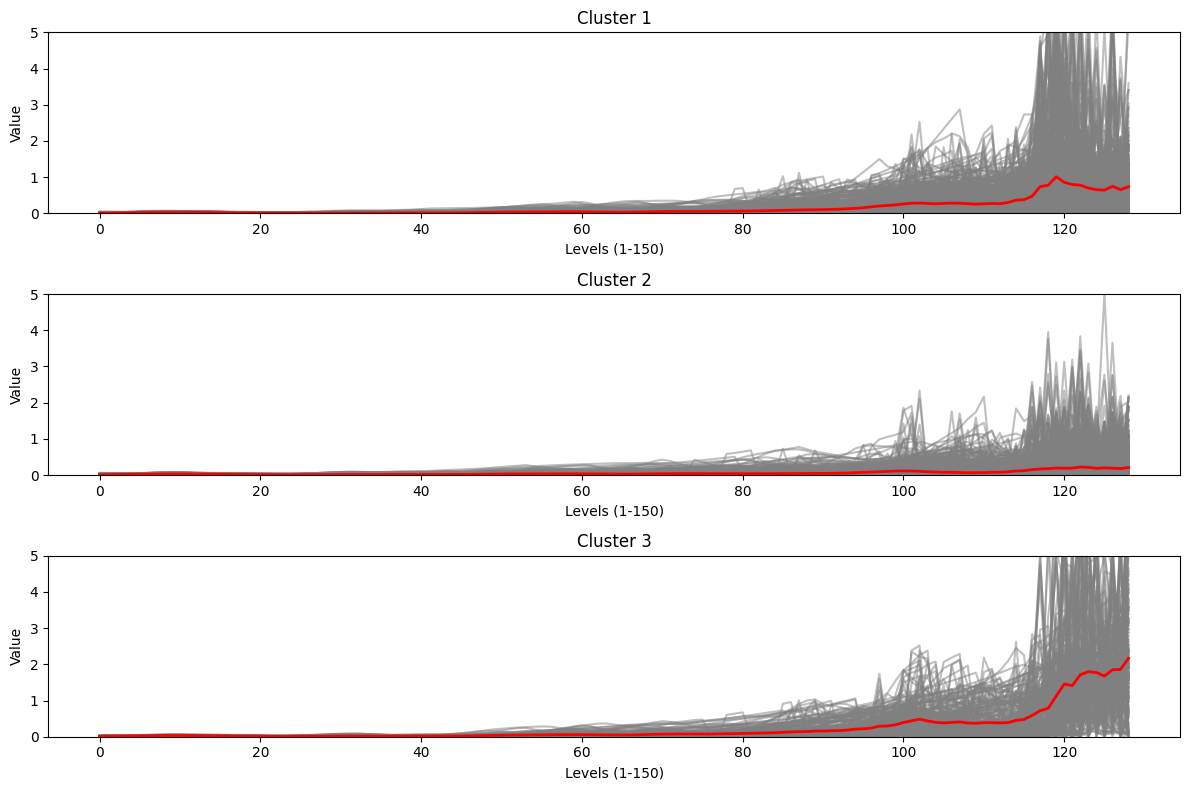

In [90]:
import pywt
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

data=pd.read_csv("0902_full_lv130.csv",encoding='utf-8')

cols_to_keep = list(data.columns[:130])
additional_cols = ['total_ad','total_purchase','final_currency_usage_total','final_dia_currency_usage_total','binger']
# 앞 150개의 컬럼과 특정 컬럼들을 결합
cols_to_keep.extend(additional_cols)

# 해당 컬럼들만 남기고 나머지 컬럼 삭제
data = data[cols_to_keep]


# 웨이블릿 변환을 위한 데이터 선택 (2번 열부터 100번 열까지)
curves_data = data.iloc[:, 1:130].values  # 2번 열부터 100번 열까지 선택

# LOESS 적용 함수 정의
def apply_loess(curve, frac=0.1):
    """
    curve: 원본 곡선 데이터 (1차원 배열)
    frac: LOESS에서 사용하는 로컬 윈도우 크기 (0에서 1 사이의 값)
    """
    x = np.arange(len(curve))  # x축 데이터 포인트 생성 (1, 2, 3, ..., N)
    loess_result = sm.nonparametric.lowess(curve, x, frac=frac)  # LOESS 적용
    return loess_result[:, 1]  # 평활화된 y값 반환

# 각 곡선에 LOESS 적용
loess_curves = np.array([apply_loess(curve, frac=0.1) for curve in curves_data])

# KMeans 클러스터링 수행
kmeans = KMeans(n_clusters=3, random_state=42)
labels_loess = kmeans.fit_predict(loess_curves)
data['cluster'] = labels_loess

# 클러스터 결과 시각화
plt.figure(figsize=(12, 8))

for cluster in range(3):  # 각 클러스터에 대해 반복
    plt.subplot(3, 1, cluster + 1)
    for curve in loess_curves[labels_loess == cluster]:  # 해당 클러스터의 곡선들을 그리기
        plt.plot(curve, color='gray', alpha=0.5)
    plt.plot(loess_curves[labels_loess == cluster].mean(axis=0), color='red', linewidth=2)  # 평균 곡선
    plt.title(f'Cluster {cluster + 1}')
    plt.xlabel('Levels (1-150)')
    plt.ylabel('Value')
    plt.ylim(0, 5)  # 필요시 Y축 범위 조정

plt.tight_layout()
plt.show()

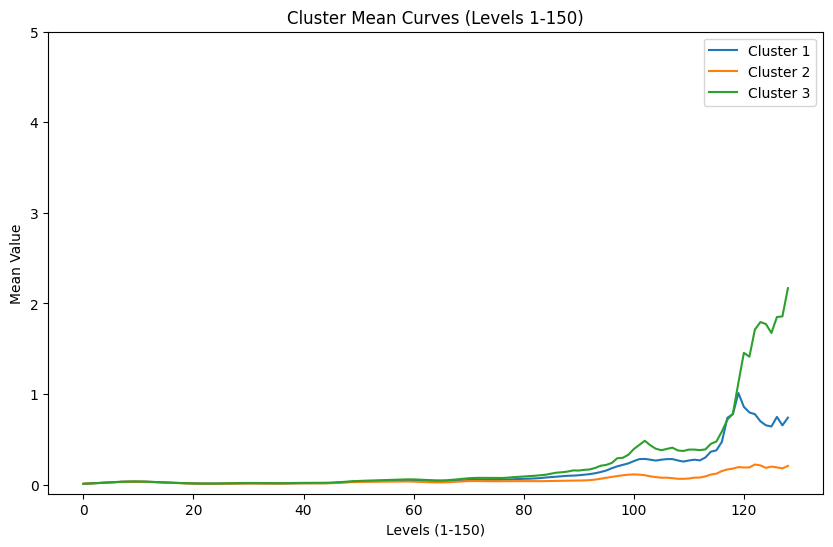

In [91]:
# 클러스터별 평균 곡선을 하나의 그래프로 시각화
plt.figure(figsize=(10, 6))

for cluster in range(3):  # 각 클러스터에 대해 반복
    mean_curve = loess_curves[labels_loess == cluster].mean(axis=0)
    plt.plot(mean_curve, label=f'Cluster {cluster + 1}')

plt.title('Cluster Mean Curves (Levels 1-150)')
plt.xlabel('Levels (1-150)')
plt.ylabel('Mean Value')
plt.ylim(-0.1, 5)  # 필요시 Y축 범위 조정
plt.legend()
plt.show()

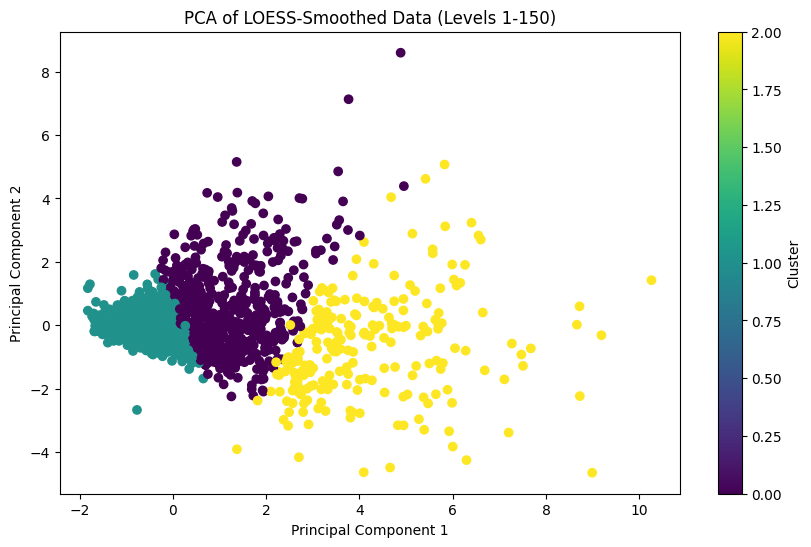

Explained Variance by Component 1: 0.39
Explained Variance by Component 2: 0.11


In [92]:
# PCA 분석 수행
pca = PCA(n_components=3)
pca_result = pca.fit_transform(loess_curves)

# PCA 결과 시각화 (클러스터별)
plt.figure(figsize=(10, 6))
scatter = plt.scatter(pca_result[:, 0], pca_result[:, 1], c=labels_loess, cmap='viridis')
plt.title('PCA of LOESS-Smoothed Data (Levels 1-150)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(scatter, label='Cluster')
plt.show()

# PCA 설명력 (Variance Explained)
explained_variance = pca.explained_variance_ratio_
print(f"Explained Variance by Component 1: {explained_variance[0]:.2f}")
print(f"Explained Variance by Component 2: {explained_variance[1]:.2f}")

In [93]:

# Cluster별로 그룹화하여 'binge' 열의 비율을 계산
binge_ratios = data.groupby('cluster')['binger'].value_counts(normalize=True).unstack()

# 결과 확인
print(binge_ratios)
binge_number = data.groupby('cluster')['binger'].value_counts().unstack()

# 결과 확인
print(binge_number)

binger          0         1
cluster                    
0        0.334539  0.665461
1        0.379444  0.620556
2        0.394068  0.605932
binger     0     1
cluster           
0        185   368
1        683  1117
2         93   143


## wavelet 방식

In [94]:
data=pd.read_csv("0902_full_lv130.csv",encoding='utf-8')

cols_to_keep = list(data.columns[:130])
additional_cols = ['total_ad','total_purchase','final_currency_usage_total','final_dia_currency_usage_total','binge','binger']
# 앞 150개의 컬럼과 특정 컬럼들을 결합
cols_to_keep.extend(additional_cols)

# 해당 컬럼들만 남기고 나머지 컬럼 삭제
data = data[cols_to_keep]
data

,player_slug,2,3,4,5,6,7,8,9,10,...,127,128,129,130,total_ad,total_purchase,final_currency_usage_total,final_dia_currency_usage_total,binge,binger
0,2021-11-01T10:41:53.949Z,0.020556,0.004167,0.006111,0.006667,0.019722,0.021389,0.023056,0.030278,0.032778,...,0.074167,0.162222,0.873056,0.675000,28.0,0.0,5000000,4340,1,1
1,2021-11-02T08:35:43.730Z,0.010278,0.004444,0.009444,0.013611,0.021111,0.022500,0.022222,0.025833,0.033611,...,0.170000,0.005278,0.590611,0.003056,84.0,0.0,11300300,5143,1,0
2,2021-11-02T13:26:32.660Z,0.011389,0.004722,0.028333,0.013889,0.028333,0.024167,0.021389,0.028333,0.031389,...,1.325556,0.777667,0.166944,1.106667,50.0,0.0,25562400,8116,1,1
3,2021-11-03T00:24:04.455Z,0.007222,0.003611,0.008611,0.009722,0.018611,0.023611,0.023889,0.028889,0.033056,...,0.813333,0.650556,0.633889,0.592500,44.0,0.0,1800600,6000,1,0
4,2021-11-05T03:40:46.672Z,0.020833,0.007222,0.015278,0.020278,0.023056,0.025556,0.061667,0.033889,0.037222,...,1.041667,0.861389,0.440278,0.367500,1.0,0.0,350000,6020,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2584,2022-03-24T16:37:29.569Z,0.008333,0.003611,0.009444,0.008889,0.020278,0.024167,0.028056,0.034167,0.037500,...,0.131944,1.632778,0.804722,0.854722,11.0,23100.0,9050300,8605,1,1
2585,2022-03-24T17:09:04.286Z,0.019722,0.012500,0.034167,0.026667,0.014722,0.023944,0.025278,0.027778,0.036389,...,1.264722,1.300556,1.375833,1.447222,18.0,0.0,77900000,2100,1,1
2586,2022-03-26T06:10:16.223Z,0.010556,0.017222,0.015000,0.016111,0.019722,0.022778,0.023333,0.088889,0.036389,...,0.921944,1.996111,0.980833,1.096667,33.0,23100.0,3051200,6057,1,0
2587,2022-03-27T00:08:37.994Z,0.122500,0.008611,0.020556,0.016389,0.028611,0.024167,0.127389,0.029444,0.033889,...,1.460833,1.552500,1.646667,1.733056,8.0,56100.0,96000600,408,1,0


In [95]:
# 각 곡선에 웨이블릿 변환 적용
curves_data = data.iloc[:, 1:130].values  # 2번 열부터 100번 열까지 선택

coeffs = [pywt.wavedec(curve, 'db4', level=4) for curve in curves_data]
# 모든 웨이블릿 계수를 하나의 배열로 병합
coeffs_flat = np.array([np.concatenate(c) for c in coeffs])

# KMeans 클러스터링 수행
kmeans = KMeans(n_clusters=2, random_state=42)
labels = kmeans.fit_predict(coeffs_flat)

# 클러스터 레이블을 원본 데이터에 추가
data['cluster'] = labels

c:\Users\sunwoong\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


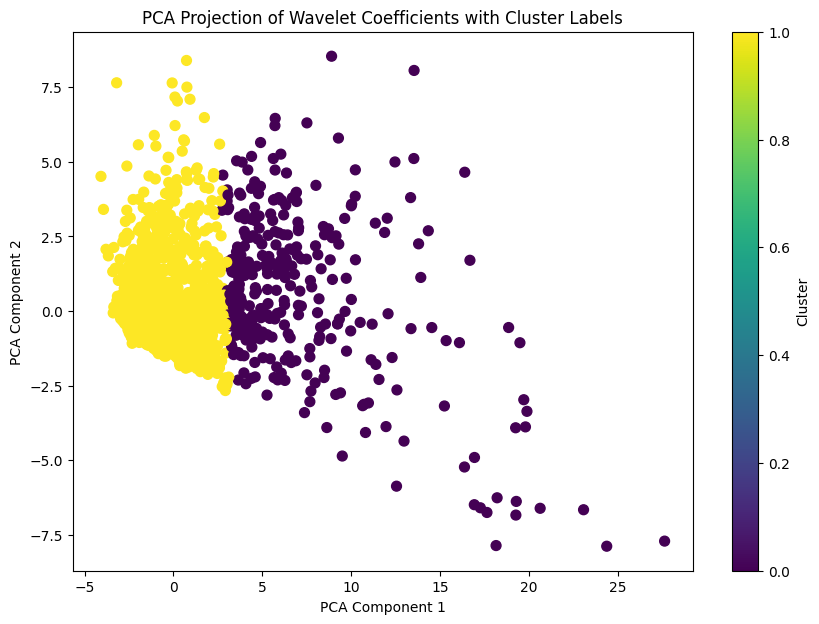

array([0.48997287, 0.10299804, 0.0756083 ])

In [96]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# PCA를 사용하여 데이터를 2차원으로 축소
pca = PCA(n_components=3)
coeffs_pca = pca.fit_transform(coeffs_flat)

# 클러스터 결과를 2차원 공간에 시각화
plt.figure(figsize=(10, 7))
plt.scatter(coeffs_pca[:, 0], coeffs_pca[:, 1], c=labels, cmap='viridis', s=50)
plt.title('PCA Projection of Wavelet Coefficients with Cluster Labels')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster')
plt.show()

# PCA 설명력 (Variance Explained)
explained_variance = pca.explained_variance_ratio_
explained_variance

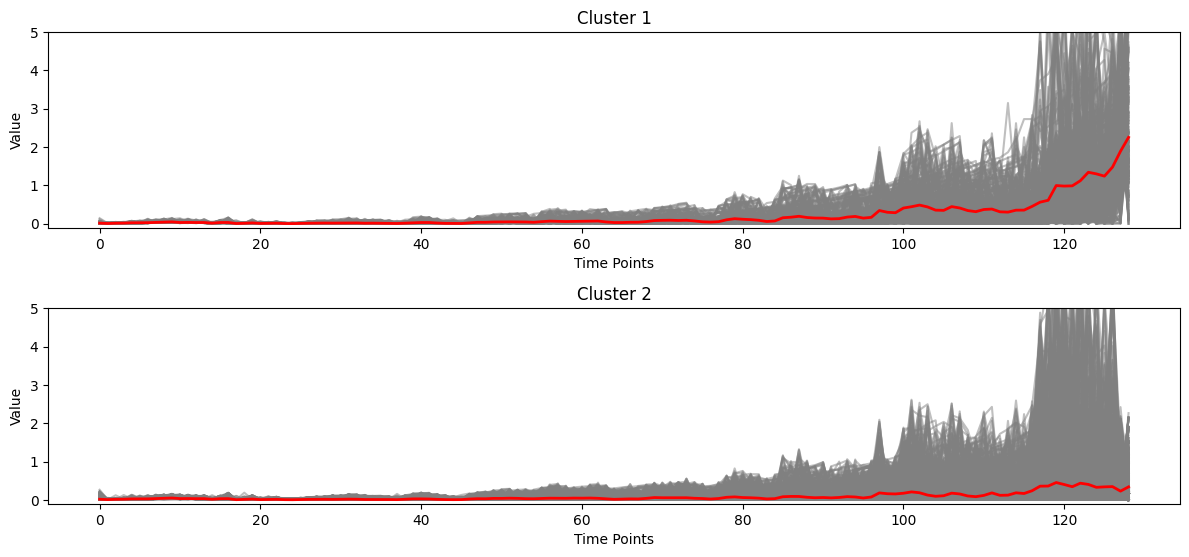

In [97]:
# 클러스터별 곡선 시각화
plt.figure(figsize=(12, 8))

for cluster in range(2):  # 각 클러스터에 대해 반복
    plt.subplot(3, 1, cluster + 1)
    for curve in curves_data[labels == cluster]:
        plt.plot(curve, color='gray', alpha=0.5)  # 개별 곡선
    plt.plot(curves_data[labels == cluster].mean(axis=0), color='red', linewidth=2)  # 평균 곡선
    plt.title(f'Cluster {cluster + 1}')
    plt.xlabel('Time Points')
    plt.ylabel('Value')
    plt.ylim(-0.1, 5)

plt.tight_layout()
plt.show()


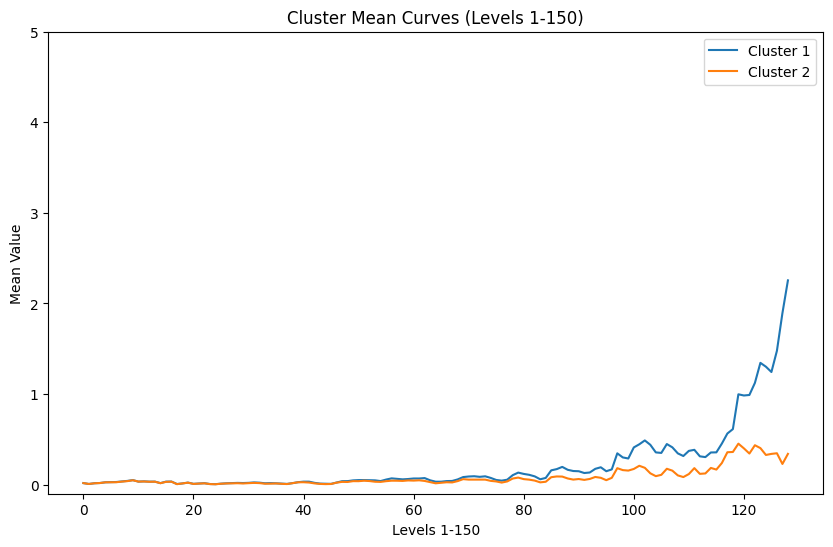

In [98]:
# 클러스터별 평균 곡선을 하나의 그래프로 시각화
plt.figure(figsize=(10, 6))

for cluster in range(2):  # 각 클러스터에 대해 반복
    mean_curve = curves_data[labels == cluster].mean(axis=0)
    plt.plot(mean_curve, label=f'Cluster {cluster + 1}')

plt.title('Cluster Mean Curves (Levels 1-150)')
plt.xlabel('Levels 1-150')
plt.ylabel('Mean Value')
plt.ylim(-0.1, 5)  # 필요시 Y축 범위 조정
plt.legend()
plt.show()

In [99]:

# Cluster별로 그룹화하여 'binge' 열의 비율을 계산
binge_ratios = data.groupby('cluster')['binger'].value_counts(normalize=True).unstack()

# 결과 확인
print(binge_ratios)
binge_number = data.groupby('cluster')['binger'].value_counts().unstack()

# 결과 확인
print(binge_number)

binger          0         1
cluster                    
0        0.380062  0.619938
1        0.369929  0.630071
binger     0     1
cluster           
0        122   199
1        839  1429


## 뒷 레벨의 결과 prediction

In [100]:
data

,player_slug,2,3,4,5,6,7,8,9,10,...,128,129,130,total_ad,total_purchase,final_currency_usage_total,final_dia_currency_usage_total,binge,binger,cluster
0,2021-11-01T10:41:53.949Z,0.020556,0.004167,0.006111,0.006667,0.019722,0.021389,0.023056,0.030278,0.032778,...,0.162222,0.873056,0.675000,28.0,0.0,5000000,4340,1,1,1
1,2021-11-02T08:35:43.730Z,0.010278,0.004444,0.009444,0.013611,0.021111,0.022500,0.022222,0.025833,0.033611,...,0.005278,0.590611,0.003056,84.0,0.0,11300300,5143,1,0,1
2,2021-11-02T13:26:32.660Z,0.011389,0.004722,0.028333,0.013889,0.028333,0.024167,0.021389,0.028333,0.031389,...,0.777667,0.166944,1.106667,50.0,0.0,25562400,8116,1,1,1
3,2021-11-03T00:24:04.455Z,0.007222,0.003611,0.008611,0.009722,0.018611,0.023611,0.023889,0.028889,0.033056,...,0.650556,0.633889,0.592500,44.0,0.0,1800600,6000,1,0,1
4,2021-11-05T03:40:46.672Z,0.020833,0.007222,0.015278,0.020278,0.023056,0.025556,0.061667,0.033889,0.037222,...,0.861389,0.440278,0.367500,1.0,0.0,350000,6020,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2584,2022-03-24T16:37:29.569Z,0.008333,0.003611,0.009444,0.008889,0.020278,0.024167,0.028056,0.034167,0.037500,...,1.632778,0.804722,0.854722,11.0,23100.0,9050300,8605,1,1,1
2585,2022-03-24T17:09:04.286Z,0.019722,0.012500,0.034167,0.026667,0.014722,0.023944,0.025278,0.027778,0.036389,...,1.300556,1.375833,1.447222,18.0,0.0,77900000,2100,1,1,0
2586,2022-03-26T06:10:16.223Z,0.010556,0.017222,0.015000,0.016111,0.019722,0.022778,0.023333,0.088889,0.036389,...,1.996111,0.980833,1.096667,33.0,23100.0,3051200,6057,1,0,0
2587,2022-03-27T00:08:37.994Z,0.122500,0.008611,0.020556,0.016389,0.028611,0.024167,0.127389,0.029444,0.033889,...,1.552500,1.646667,1.733056,8.0,56100.0,96000600,408,1,0,0


In [101]:
# 150레벨 클러스터링
# 각 곡선에 웨이블릿 변환 적용
curves_data = data.iloc[:, 1:100].values  # 2번 열부터 100번 열까지 선택

coeffs = [pywt.wavedec(curve, 'db4', level=4) for curve in curves_data]
# 모든 웨이블릿 계수를 하나의 배열로 병합
coeffs_flat = np.array([np.concatenate(c) for c in coeffs])

# KMeans 클러스터링 수행
kmeans = KMeans(n_clusters=2, random_state=42)
labels = kmeans.fit_predict(coeffs_flat)

# 클러스터 레이블을 원본 데이터에 추가
data['cluster_lv100'] = labels

c:\Users\sunwoong\AppData\Local\Programs\Python\Python311\Lib\site-packages\pywt\_multilevel.py:43: UserWarning: Level value of 4 is too high: all coefficients will experience boundary effects.
  warnings.warn(
c:\Users\sunwoong\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


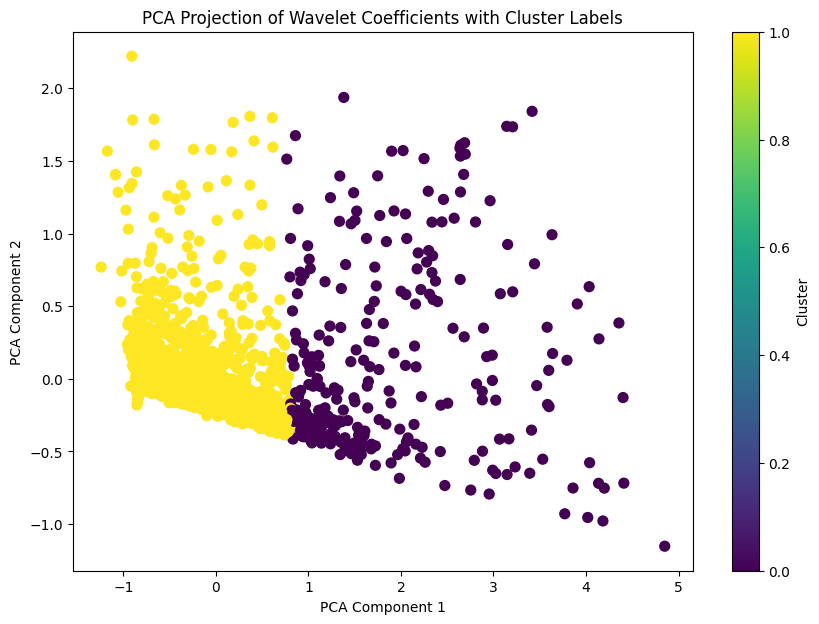

array([0.57201038, 0.09550579, 0.05274692])

In [102]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# PCA를 사용하여 데이터를 2차원으로 축소
pca = PCA(n_components=3)
coeffs_pca = pca.fit_transform(coeffs_flat)

# 클러스터 결과를 2차원 공간에 시각화
plt.figure(figsize=(10, 7))
plt.scatter(coeffs_pca[:, 0], coeffs_pca[:, 1], c=labels, cmap='viridis', s=50)
plt.title('PCA Projection of Wavelet Coefficients with Cluster Labels')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster')
plt.show()

# PCA 설명력 (Variance Explained)
explained_variance = pca.explained_variance_ratio_
explained_variance

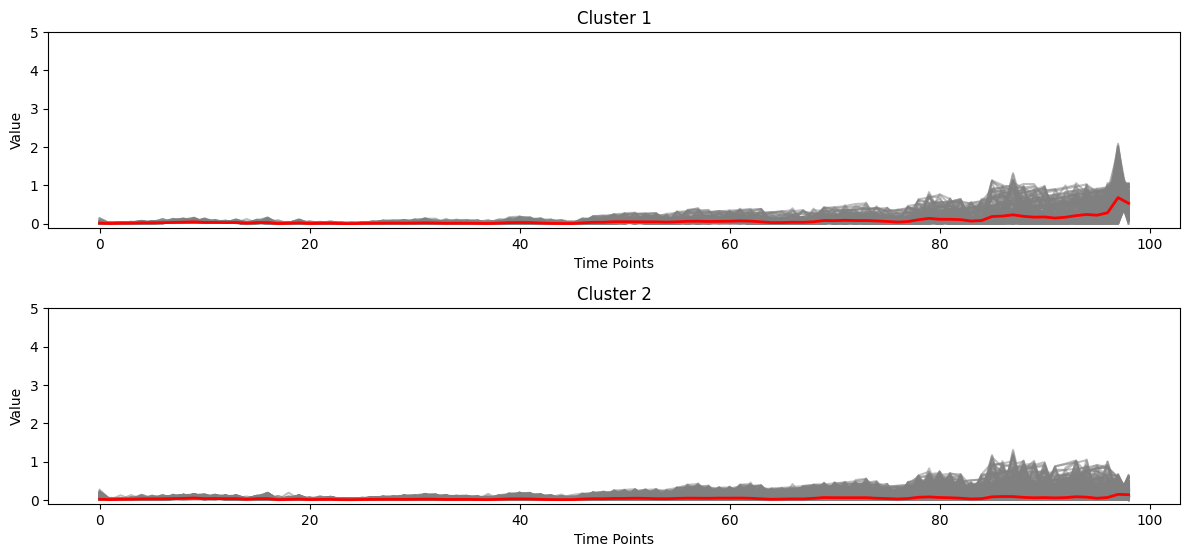

In [103]:
# 클러스터별 곡선 시각화
plt.figure(figsize=(12, 8))

for cluster in range(2):  # 각 클러스터에 대해 반복
    plt.subplot(3, 1, cluster + 1)
    for curve in curves_data[labels == cluster]:
        plt.plot(curve, color='gray', alpha=0.5)  # 개별 곡선
    plt.plot(curves_data[labels == cluster].mean(axis=0), color='red', linewidth=2)  # 평균 곡선
    plt.title(f'Cluster {cluster + 1}')
    plt.xlabel('Time Points')
    plt.ylabel('Value')
    plt.ylim(-0.1, 5)

plt.tight_layout()
plt.show()


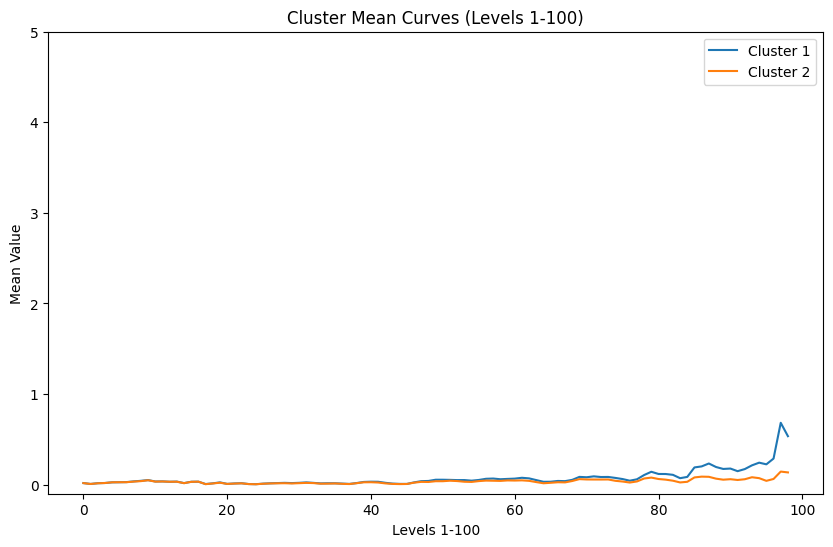

In [104]:
# 클러스터별 평균 곡선을 하나의 그래프로 시각화
plt.figure(figsize=(10, 6))

for cluster in range(2):  # 각 클러스터에 대해 반복
    mean_curve = curves_data[labels == cluster].mean(axis=0)
    plt.plot(mean_curve, label=f'Cluster {cluster + 1}')

plt.title('Cluster Mean Curves (Levels 1-100)')
plt.xlabel('Levels 1-100')
plt.ylabel('Mean Value')
plt.ylim(-0.1, 5)  # 필요시 Y축 범위 조정
plt.legend()
plt.show()

In [105]:
data.to_csv("0902_prediction_130.csv",index=False,encoding='utf-8')

In [338]:
data

,player_slug,2,3,4,5,6,7,8,9,10,...,149,150,total_ad,total_purchase,final_currency_usage_total,final_dia_currency_usage_total,binge,binger,cluster,cluster_lv100
0,2021-11-02T13:26:32.660Z,0.011389,0.004722,0.028333,0.013889,0.028333,0.024167,0.021389,0.028333,0.031389,...,1.477833,0.000278,50.0,0.0,27963000,15481,1,1,1,1
1,2021-11-07T02:08:43.788Z,0.010278,0.020833,0.015556,0.018333,0.018056,0.023056,0.025000,0.058611,0.039167,...,2.045833,2.550278,16.0,0.0,61350600,613,0,1,0,0
2,2021-11-07T15:46:35.878Z,0.009167,0.004444,0.007222,0.016944,0.013611,0.023056,0.021944,0.026667,0.030556,...,0.065000,0.003889,1.0,416900.0,20050000,121759,1,1,1,0
3,2021-11-09T12:36:41.935Z,0.010556,0.005833,0.033889,0.032778,0.042778,0.032222,0.022778,0.026944,0.032222,...,3.741944,0.077222,17.0,13200.0,5500700,14863,0,1,0,0
4,2021-11-10T13:52:38.359Z,0.010000,0.003889,0.006389,0.014444,0.013333,0.026111,0.030833,0.026389,0.033056,...,2.828889,1.571111,3.0,0.0,71800600,116,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
921,2022-03-20T08:23:38.716Z,0.036111,0.004722,0.009444,0.012778,0.015278,0.021111,0.053611,0.029167,0.125000,...,2.626667,2.046667,97.0,0.0,56100100,13821,1,1,0,0
922,2022-03-22T23:02:07.011Z,0.012500,0.009167,0.013333,0.017222,0.060000,0.024444,0.030278,0.032222,0.043556,...,0.195833,0.130833,52.0,0.0,48801000,19777,1,1,1,0
923,2022-03-24T16:37:29.569Z,0.008333,0.003611,0.009444,0.008889,0.020278,0.024167,0.028056,0.034167,0.037500,...,2.874722,1.329167,11.0,23100.0,26050600,8657,1,1,0,0
924,2022-03-24T17:09:04.286Z,0.019722,0.012500,0.034167,0.026667,0.014722,0.023944,0.025278,0.027778,0.036389,...,3.266944,3.425000,18.0,0.0,125200000,3100,1,1,0,1


In [106]:
features_to_use = list(data.columns[1:101]) + [
    'total_ad', 'total_purchase', 'final_currency_usage_total',
    'final_dia_currency_usage_total', 'binger','cluster_lv100'
]
X = data[features_to_use]
y = data['cluster']

In [107]:
import pandas as pd
import numpy as np
import pywt
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
# 훈련/검증/테스트 데이터 분할
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)  # 0.25 * 0.8 = 0.2

# 랜덤 포레스트 모델 훈련
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# 검증 데이터에 대해 예측 수행
y_valid_pred = model.predict(X_valid)

# 검증 데이터 예측 결과 평가
print("Validation Set Performance:")
print(classification_report(y_valid, y_valid_pred))

# 테스트 데이터에 대해 예측 수행
y_test_pred = model.predict(X_test)

# 테스트 데이터 예측 결과 평가
print("Test Set Performance:")
print(classification_report(y_test, y_test_pred))


Validation Set Performance:
              precision    recall  f1-score   support

           0       0.33      0.08      0.12        65
           1       0.88      0.98      0.93       453

    accuracy                           0.86       518
   macro avg       0.61      0.53      0.53       518
weighted avg       0.81      0.86      0.83       518

Test Set Performance:
              precision    recall  f1-score   support

           0       0.58      0.11      0.19        62
           1       0.89      0.99      0.94       456

    accuracy                           0.88       518
   macro avg       0.74      0.55      0.56       518
weighted avg       0.85      0.88      0.85       518

